### Empirical Example for RobustiPY (Type 5)!

##### This example is designed to show how RobustiPy can be estimated with multiple dependent variables. In particular, it replicates the wonderful paper by [Amy Orben & Andrew K. Przybylski in Nature Human Behaviour, 2019](https://www.nature.com/articles/s41562-018-0506-1). Data comes from the UK Data Service [here](https://beta.ukdataservice.ac.uk/datacatalogue/series/series?id=2000031). Code comes from Amy's GitHub page, available [here](https://github.com/OrbenAmy/NHB_2019/tree/master).


In [1]:
import pandas as pd
from robustipy.models import OLSRobust
import warnings
from robustipy.prototypes import MissingValueWarning

# Ignore all MissingValueWarning warnings from robustipy
warnings.filterwarnings(
    action="ignore",
    category=MissingValueWarning,
    module=r"robustipy\.prototypes"
)


n_draws = 1000

In [2]:
data = pd.read_csv('../data/nhb_2019/1_3_prep_mcs_data.csv', low_memory=False)

## No-Controls, participant

In [3]:
y = ["fcmdsa00r",
    "fcmdsb00r",
    "fcmdsc00r",
    "fcmdsd00r",
    "fcmdse00r",
    "fcmdsf00r",
    "fcmdsg00r",
    "fcmdsh00r",
    "fcmdsi00r",
    "fcmdsj00r",
    "fcmdsk00r",
    "fcmdsl00r",
    "fcmdsm00r",
    "fcsati00r",
    "fcgdql00r",
    "fcdowl00r",
    "fcvalu00r",
    "fcgdsf00r",
    "fcscwk00r",
    "fcwylk00r",
    "fcfmly00r",
    "fcfrns00r",
    "fcschl00r",
    "fclife00r",
    ]
x = [
    "tech"
]
c= []

orben_1 = OLSRobust(y=y, x=x, data=data)
orben_1.fit(controls=c, draws=n_draws, composite_sample=100)
orben_1_results = orben_1.get_results()

Calculating Composite Ys


Output()

[OLSRobust] Running with n_cpu=31, draws=1000


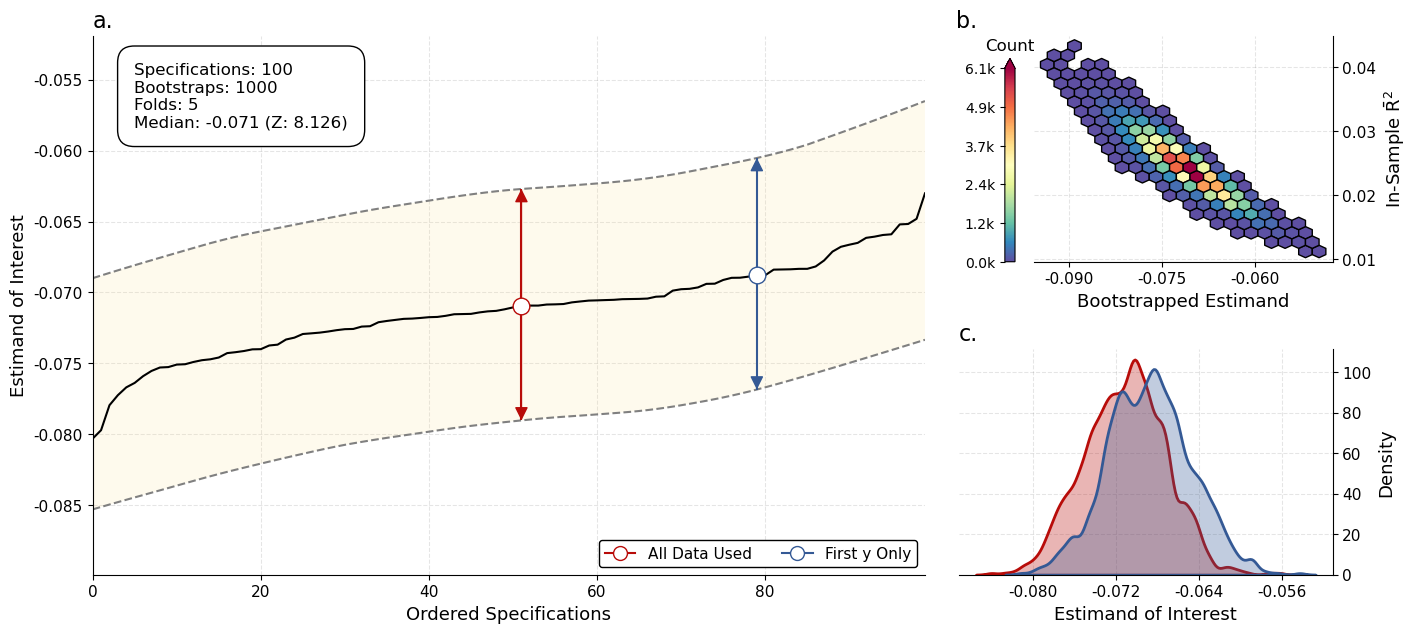

In [4]:
orben_1_results.plot(ic='hqic',
                     ext='pdf',
                     ci=0.95,
                     loess=True,
                     project_name='nhb_2019_nocontrols_participant',
                     figpath = '../figures',
                     figsize=(16, 7)
                    )

In [5]:
orben_1_results.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'fcmdsi00r', 'fcmdsc00r', 'fcmdsd00r', 'fcmdsa00r', 'fcmdsh00r', 'fcwylk00r', 'fcschl00r', 'fcmdsm00r', 'fcmdse00r', 'fclife00r', 'fcdowl00r', 'fcvalu00r', 'fcgdql00r', 'fcmdsf00r', 'fcmdsl00r', 'fcgdsf00r', 'fcmdsg00r', 'fcfrns00r', 'fcmdsb00r', 'fcscwk00r', 'fcmdsk00r', 'fcfmly00r', 'fcmdsj00r', 'fcsati00r'}
Independent variable: ['tech', 'const']
Number of possible controls: 0
Number of draws: 1000
Number of folds: 5
Number of specifications: 100
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): -0.07 (p-value: 1.0)
Median beta (all bootstraps and specifications): -0.07
Min beta (all specifications, no resampling): -0.07
Min beta (all bootstraps and specifications): -0.09
Max beta (all specifications, no resampling): -0.07
Max beta (all bootstraps and specifications): -0.05
Significant portion of beta (all specifications, no resampling): 1.0 (p-value: 0.97)
Si

## Control, Participant

In [6]:
y = ["fcmdsa00r",
    "fcmdsb00r",
    "fcmdsc00r",
    "fcmdsd00r",
    "fcmdse00r",
    "fcmdsf00r",
    "fcmdsg00r",
    "fcmdsh00r",
    "fcmdsi00r",
    "fcmdsj00r",
    "fcmdsk00r",
    "fcmdsl00r",
    "fcmdsm00r",
    "fcsati00r",
    "fcgdql00r",
    "fcdowl00r",
    "fcvalu00r",
    "fcgdsf00r",
    "fcscwk00r",
    "fcwylk00r",
    "fcfmly00r",
    "fcfrns00r",
    "fcschl00r",
    "fclife00r",
    ]
x = [
    "tech",
    "edumot",
    "fd06e00",
    "clpar",
    "fcpaab00",
    "fpwrdscm",
    "fdacaq00",
    "fd05s00",
    "fpclsi00",
    "fpchti00",
    "fdkessl",
    "fdtots00",
    "foede000"
]
c= []

orben_2 = OLSRobust(y=y, x=x, data=data)
orben_2.fit(controls=c, draws=n_draws, composite_sample=100)
orben_2_results = orben_2.get_results()

Calculating Composite Ys


Output()

[OLSRobust] Running with n_cpu=31, draws=1000


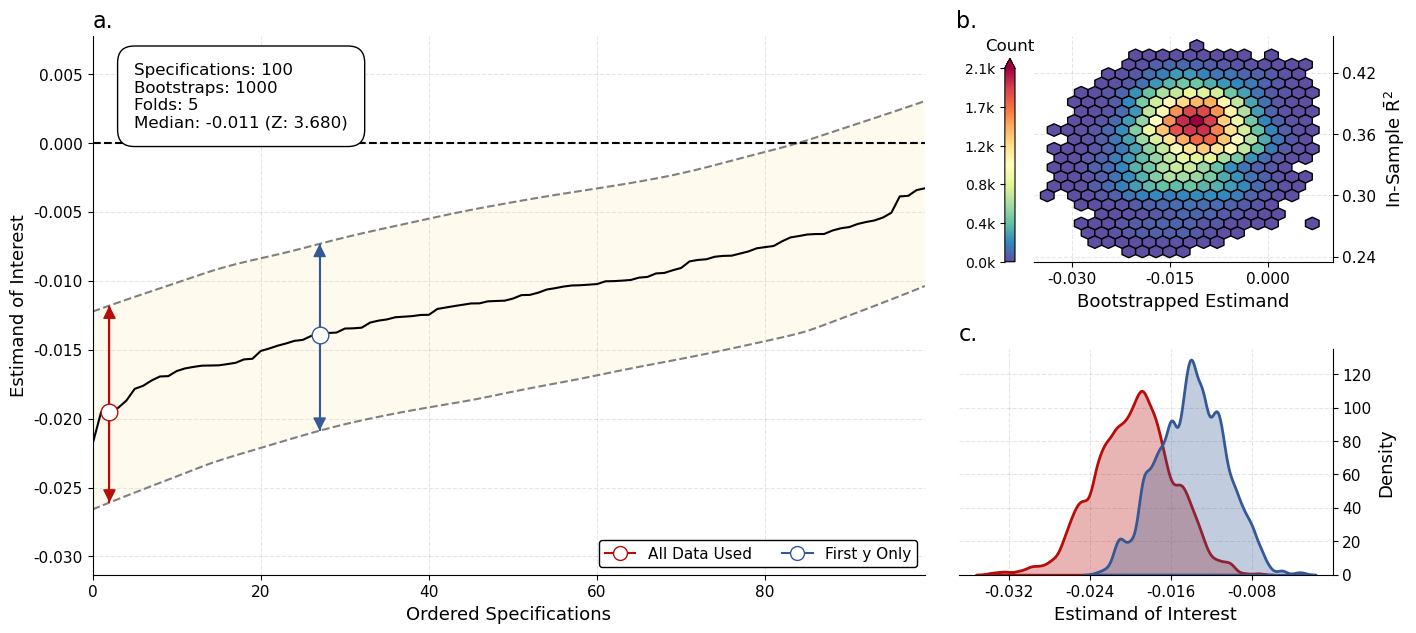

In [7]:
orben_2_results.plot(ic='hqic',
                     ext='pdf',
                     ci=0.95,
                     loess=True,
                     project_name='nhb_2019_controls_participant',
                     figpath = '../figures',
                     figsize=(16, 7)
                    )

In [8]:
orben_2_results.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'fcmdsi00r', 'fcmdsc00r', 'fcmdsd00r', 'fcmdsa00r', 'fcmdsh00r', 'fcwylk00r', 'fcschl00r', 'fcmdsm00r', 'fcmdse00r', 'fclife00r', 'fcdowl00r', 'fcvalu00r', 'fcgdql00r', 'fcmdsf00r', 'fcmdsl00r', 'fcgdsf00r', 'fcmdsg00r', 'fcfrns00r', 'fcmdsb00r', 'fcscwk00r', 'fcmdsk00r', 'fcfmly00r', 'fcmdsj00r', 'fcsati00r'}
Independent variable: ['tech', 'edumot', 'fd06e00', 'clpar', 'fcpaab00', 'fpwrdscm', 'fdacaq00', 'fd05s00', 'fpclsi00', 'fpchti00', 'fdkessl', 'fdtots00', 'foede000', 'const']
Number of possible controls: 0
Number of draws: 1000
Number of folds: 5
Number of specifications: 100
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): -0.02 (p-value: 1.0)
Median beta (all bootstraps and specifications): -0.01
Min beta (all specifications, no resampling): -0.02
Min beta (all bootstraps and specifications): -0.03
Max beta (all specifications, no resampling): -0.02
Max

## No Controls, Primary carers

In [9]:
y = ["fpsdpf00",
    "fpsdro00",
    "fpsdhs00",
    "fpsdsr00",
    "fpsdtt00",
    "fpsdsp00",
    "fpsdor00",
    "fpsdmw00",
    "fpsdhu00",
    "fpsdfs00",
    "fpsdgf00",
    "fpsdfb00",
    "fpsdud00",
    "fpsdlc00",
    "fpsddc00",
    "fpsdnc00",
    "fpsdky00",
    "fpsdoa00",
    "fpsdpb00",
    "fpsdvh00",
    "fpsdst00",
    "fpsdcs00",
    "fpsdgb00",
    "fpsdfe00",
    "fpsdte00"
    ]
x = [
    "tech"
]
c= []

orben_3 = OLSRobust(y=y, x=x, data=data)
orben_3.fit(controls=c, draws=n_draws, composite_sample=100)
orben_3_results = orben_3.get_results()

Calculating Composite Ys


Output()

[OLSRobust] Running with n_cpu=31, draws=1000


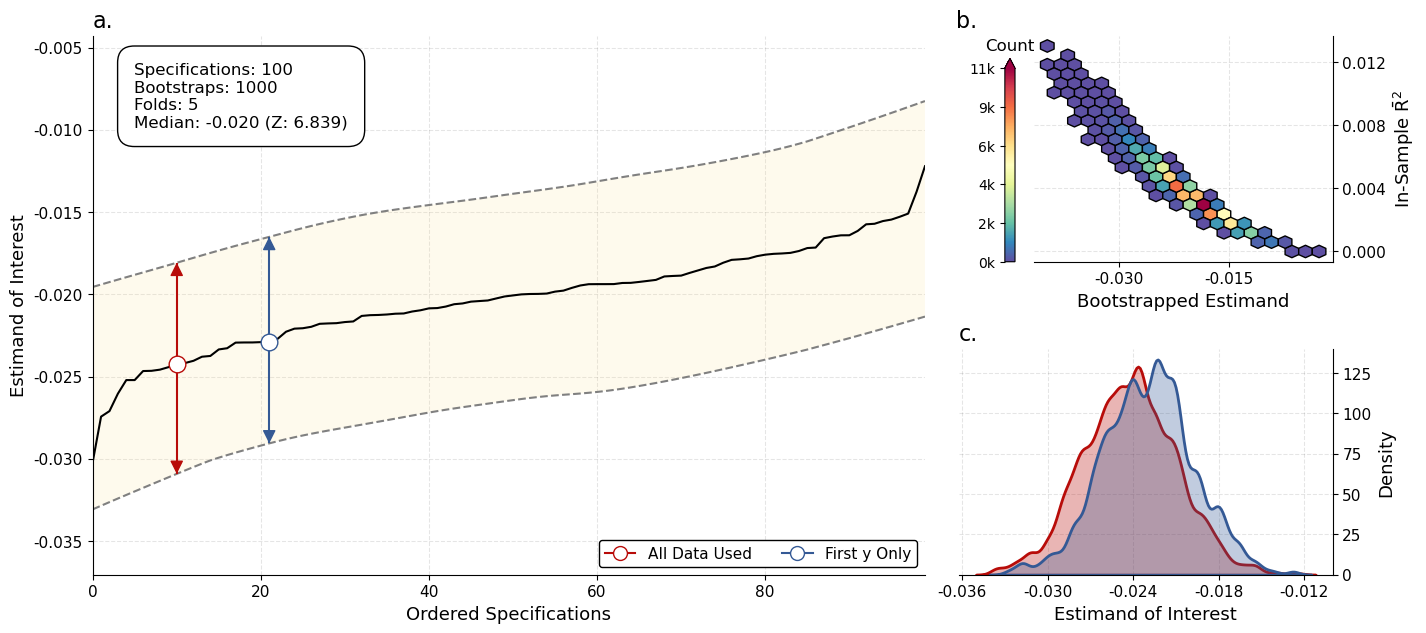

In [10]:
orben_3_results.plot(ic='hqic',
                     ext='pdf',
                     ci=0.95,
                     loess=True,
                     project_name='nhb_2019_nocontrols_primarycarers',
                     figpath = '../figures',
                     figsize=(16, 7)
                    )

In [11]:
orben_3_results.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'fpsdro00', 'fpsdor00', 'fpsdtt00', 'fpsdst00', 'fpsdhs00', 'fpsdgb00', 'fpsdky00', 'fpsdgf00', 'fpsdfb00', 'fpsdhu00', 'fpsdsp00', 'fpsdpb00', 'fpsdnc00', 'fpsdfe00', 'fpsdpf00', 'fpsddc00', 'fpsdoa00', 'fpsdmw00', 'fpsdsr00', 'fpsdfs00', 'fpsdlc00', 'fpsdvh00', 'fpsdud00', 'fpsdcs00', 'fpsdte00'}
Independent variable: ['tech', 'const']
Number of possible controls: 0
Number of draws: 1000
Number of folds: 5
Number of specifications: 100
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): -0.02 (p-value: 1.0)
Median beta (all bootstraps and specifications): -0.02
Min beta (all specifications, no resampling): -0.02
Min beta (all bootstraps and specifications): -0.04
Max beta (all specifications, no resampling): -0.02
Max beta (all bootstraps and specifications): -0.0
Significant portion of beta (all specifications, no resampling): 1.0 (p-value: 0.99)
Significant por

## Controls, Primary Carers

In [12]:
y = ["fpsdpf00",
    "fpsdro00",
    "fpsdhs00",
    "fpsdsr00",
    "fpsdtt00",
    "fpsdsp00",
    "fpsdor00",
    "fpsdmw00",
    "fpsdhu00",
    "fpsdfs00",
    "fpsdgf00",
    "fpsdfb00",
    "fpsdud00",
    "fpsdlc00",
    "fpsddc00",
    "fpsdnc00",
    "fpsdky00",
    "fpsdoa00",
    "fpsdpb00",
    "fpsdvh00",
    "fpsdst00",
    "fpsdcs00",
    "fpsdgb00",
    "fpsdfe00",
    "fpsdte00"
    ]
x = [
    "tech",
    "edumot",
    "fd06e00",
    "clpar",
    "fcpaab00",
    "fpwrdscm",
    "fdacaq00",
    "fd05s00",
    "fpclsi00",
    "fpchti00",
    "fdkessl",
    "fdtots00",
    "foede000"
]
c= []

orben_4 = OLSRobust(y=y, x=x, data=data)
orben_4.fit(controls=c, draws=n_draws, composite_sample=100)
orben_4_results = orben_4.get_results()

Calculating Composite Ys


Output()

[OLSRobust] Running with n_cpu=31, draws=1000


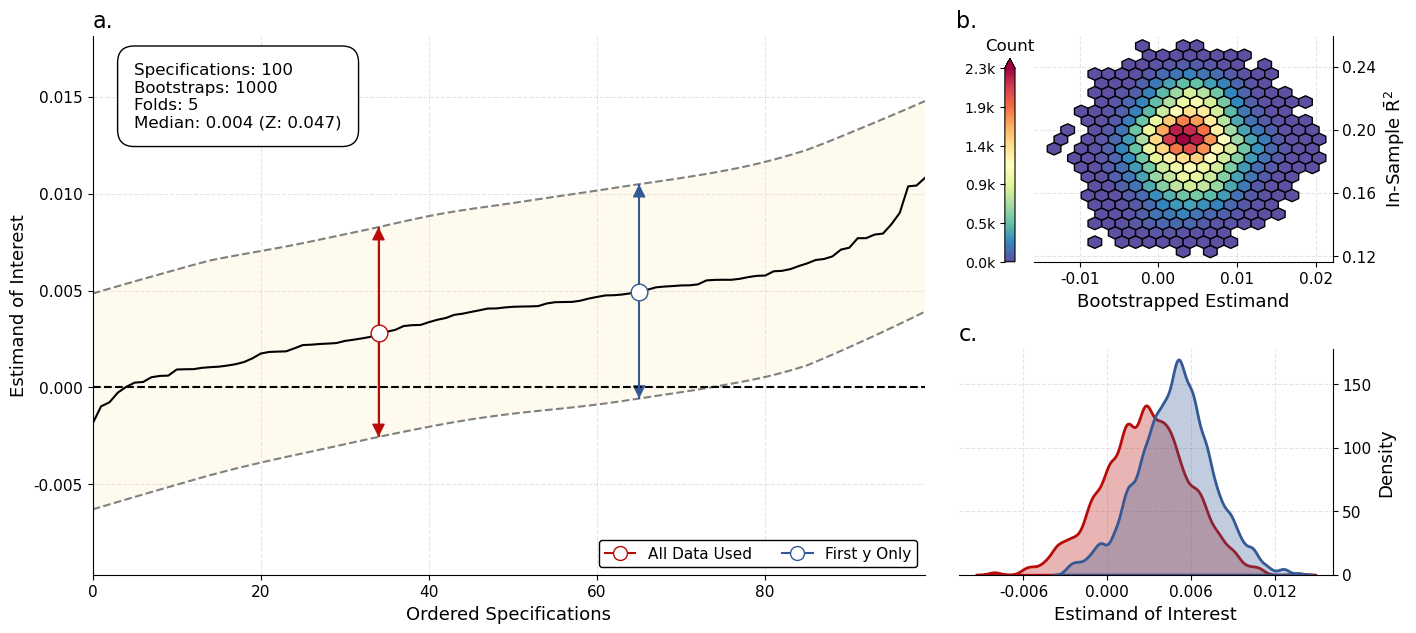

In [13]:
orben_4_results.plot(ic='hqic',
                     ext='pdf',
                     ci=0.95,
                     loess=True,
                     project_name='nhb_2019_controls_primarycarers',
                     figpath = '../figures',
                     figsize=(16, 7)
                    )

In [14]:
orben_4_results.summary(digits=2)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: {'fpsdro00', 'fpsdor00', 'fpsdtt00', 'fpsdst00', 'fpsdhs00', 'fpsdgb00', 'fpsdgf00', 'fpsdky00', 'fpsdfb00', 'fpsdhu00', 'fpsdsp00', 'fpsdpb00', 'fpsdnc00', 'fpsdfe00', 'fpsdpf00', 'fpsddc00', 'fpsdmw00', 'fpsdoa00', 'fpsdsr00', 'fpsdfs00', 'fpsdlc00', 'fpsdvh00', 'fpsdud00', 'fpsdcs00', 'fpsdte00'}
Independent variable: ['tech', 'edumot', 'fd06e00', 'clpar', 'fcpaab00', 'fpwrdscm', 'fdacaq00', 'fd05s00', 'fpclsi00', 'fpchti00', 'fdkessl', 'fdtots00', 'foede000', 'const']
Number of possible controls: 0
Number of draws: 1000
Number of folds: 5
Number of specifications: 100
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): 0.0 (p-value: 0.0)
Median beta (all bootstraps and specifications): 0.0
Min beta (all specifications, no resampling): 0.0
Min beta (all bootstraps and specifications): -0.01
Max beta (all specifications, no resampling): 0.0
Max beta (all bootstrap